#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, компании нужно прогнозировать количество заказов такси на следующий час, а нам необходимо построить модель для такого прогнозирования.


Для решения поставленной задачи будем придерживатья следующих шагов:

1) Изучим и подготовим данные для машинного обучения 

2) Создадим несколько видов ML-моделей, основанных на разных алгоритмах

3) Выберем лучший алгоритм по ряду параметров и посчитаем на нём контрольную метрику на отоженной выборке

4) Подведём итог проделанной работе

В качестве оценки предсказанния мы будем использовать метрику ```RMSE```

$$RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y_i})^2}$$

она измеряет среднеквадратическое отклонение прогнозируемых значений от фактических. Значение метрики ```RMSE``` на тестовой выборке должно быть не больше 48.

_____

## Подготовка

Импортируем все необходимые для работы библиотеки и модули:

In [1]:
import itertools
import os
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from matplotlib.colors import ListedColormap

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

my_cmap = ListedColormap(['#008080', '#FF0000', '#FF00FF', '#909497', '#239B56'])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=my_cmap.colors)
pd.set_option('max_colwidth', 1000)

Техническая часть работы - все классы, функции и пр. рабочие части кода соберём в одном месте здесь наверху, так общий код исследования будет выглядеть аккуратнее:

In [2]:
def plot_grouped(df, groupby_column):
    """функция группирует данные и рисует plot-график зависимости заказов от указанного признака"""
    
    grouped_data = df.groupby(groupby_column)['num_orders'].mean()
    
    plt.figure(figsize=(11, 3))
    plt.bar(grouped_data.index, grouped_data.values, label=groupby_column)
    plt.legend()
    plt.xlabel(groupby_column)
    plt.ylabel('количество заказов')
    plt.title(f'среднее количества заказов в зависимости от {groupby_column}', fontweight='bold')
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--');
    
    
def get_plot_by_month_2(df, *args):
    """
    функция рисует 3 plot-графика признака в диапазоне по 2 месяца на каждой оси 
    ограничений на количество признаков в фигуре нет, т.к. функция принимает args апгументов
    """
    
    fig, axes = plt.subplots(nrows=3, figsize=(12, 10))
    fig.suptitle(f'признаки {args}', fontsize=16, fontweight='bold')

    months = [('март-апрель', '2018-03', '2018-04'),
              ('май-июнь', '2018-05', '2018-06'),
              ('июль-август', '2018-07', '2018-08')]

    for i, (title, start_date, end_date) in enumerate(months):
        ax = axes[i]
        for col in args:
            ax.plot(df[col][start_date:end_date], lw=1, label=col)
        ax.set_title(title, fontweight='bold')
        ax.legend()
        ax.minorticks_on()
        ax.grid(which='major', linewidth=.5)
        ax.grid(which='minor', linewidth=.25, linestyle='--')
    plt.tight_layout();
    
    
def decomposed_plot(*args):
    """функция отрисовывает тренд, сезонность и остаток декомпозиции временного ряда"""
    
    fig, axes = plt.subplots(nrows=3, figsize=(12, 10))
    fig.suptitle('декомпозиция для количества заказов', fontsize=16, fontweight='bold')

    for n, p in enumerate(args):
        ax = axes[n]
        ax.plot(p, lw=1, label=p.name)
        ax.set_title(p.name, fontweight='bold')
        ax.legend()
        ax.minorticks_on()
        ax.grid(which='major', linewidth=.5)
        ax.grid(which='minor', linewidth=.25, linestyle='--')
    plt.tight_layout();
    

def get_bar(x, y, xlabel, ylabel, title, rotation=0, h=False, rmse_=False):
    """Функция отрисовывает столбчатую диаграмму (горизонтальную или вертикальную)"""
    
    if h:
        plt.figure(figsize=(12, 7))
        plt.barh(x, y, color='#AED6F1', ec='#2980B9')
        axis_ = 'x'
    else:
        plt.figure(figsize=(12,4))
        plt.bar(x, y, color='#AED6F1', ec='#2980B9')
        axis_ = 'y'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight='bold')
    plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', axis=axis_, linewidth=.5)
    plt.grid(which='minor', axis=axis_, linewidth=.25, linestyle='--')
    if rmse_ is not False:
        for i, v in enumerate(rmse_):
            plt.text(i-.10, v-5, str(round(v, 2)), fontweight='bold', fontsize=14);
            

def make_features(df, max_lag, rolling_size):
    """функция создаёт признаки"""
    
    df_ = df.copy()
    # месяц/неделя/день недели
    df_['month'] = df_.index.month
    df_['day'] = df_.index.day
    df_['dayofweek'] = df_.index.dayofweek
    # время суток
    df_['time_of_day'] = pd.cut(df_.index.hour, bins=[0, 6, 12, 18, 24], 
                                labels=['night', 'morning', 'afternoon', 'evening'], include_lowest=True)
    # бинарный признак для выходных дней (суббота и воскресенье)
    df_['is_weekend'] = df_.index.dayofweek.isin([5, 6]).astype(int)
    # количество заказов за предыдущий день (со сдвигом, чтоб не подглядывать)
    df_['orders_prev_day'] = df_['num_orders'].shift(24)
    # скользящее среднее
    df_[f'rolling_mean_{rolling_size}'] = df_['num_orders'].shift(1).rolling(rolling_size).mean() 
    df_[f'rolling_mean_{rolling_size*10}'] = df_['num_orders'].shift(1).rolling(rolling_size*10).mean() 
    # стандартное отклонение
    df_[f'rolling_std_{rolling_size}'] = df_['num_orders'].shift(1).rolling(rolling_size).std() 
    df_[f'rolling_std_{rolling_size*10}'] = df_['num_orders'].shift(1).rolling(rolling_size*10).std() 
    # сдвиг
    for lag in range(1, max_lag + 1):
        df_[f'lag_{lag}'] = df_['num_orders'].shift(lag)

    return df_


def adf_test(col, alpha=.05):
    """
    функция проверяет стат.гипотезу о стационарности временных рядов при помощи ADF-теста
    """
    
    st_test = adfuller(col)
    print(f'p-value = {st_test[1]:.4f}')
    if st_test[1] <= alpha:
        print('Отвергаем нулевую гипотезу о наличии единичного корня. Временной ряд стационарен.')
    else:
        print('Не удалось отвергнуть нулевую гипотезу о наличии единичного корня. Временной ряд нестационарен.')
        
        
def autocorrelation_plot(col, lags):
    """функция строит график автокорреляции временного ряда"""
    
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(col, lags=24, color='#285AEA', marker='o', linestyle='--', lw=1, ax=ax)
    for i in range(len(ax.lines)):
        line = ax.lines[i]
        line.set_markersize(8)
        line.set_markerfacecolor('none')
        line.set_markeredgecolor('#285AEA')
        line.set_markeredgewidth(1)
    ax.set_xlabel('лаг')
    ax.set_ylabel('значение автокорреляции')
    ax.set_title(f'автокорреляция {col.name}', fontweight='bold')   
    ax.set_xticks(range(lags+1), minor=False)
    ax.set_xticklabels(range(lags+1))
    ax.minorticks_on()
    ax.grid(which='major', linewidth=.5)
    ax.grid(which='minor', linewidth=.25, linestyle='--');
    
    
def final_forecast_plot(df):
    """функция строит plot-графики истинных знаяений и предсказания"""
    
    plt.figure(figsize=(12, 5))
    colors = ['#2471A3', '#CB4335']
    for i in range(len(df.columns)):
        plt.plot(df.iloc[:, i], lw=2, color=colors[i], label=df.columns[i], alpha=.9)
    plt.title('сравнение предсказания с истинными значениями', fontweight='bold')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.tight_layout();

In [3]:
class GetFinalTable:
    """класс в конструкторе заполняет финальную сводную таблицу"""
    
    pivot_table = pd.DataFrame(columns=['модель', 'RMSE на train', 'RMSE на test'])
    
    def __init__(self, name_model, RMSE_train, RMSE_test):
        self.model = name_model
        self.RMSE_train = RMSE_train
        self.RMSE_test =  RMSE_test
        
        GetFinalTable.pivot_table.loc[len(GetFinalTable.pivot_table)] =\
        [self.model, self.RMSE_train, self.RMSE_test]
        

def choosing_best_model(model, X, y, params, n_splits=7, linear_model=False, 
                        X_test=False, y_test=False, sparse=True):
    """
    функция формирует пайплайн, передаёт его GridSearchCV, по сетке находит лучшие гиперпараметры,
    возвращает предсказания и экземпляр класса GetFinalTable, который дописывает в конец сводную таблицу,
    содержащую: название алгоритма с лучшими параметрами и замеры RMSE
    """
    
    categorial_features = list(X.select_dtypes(include=['category']).columns)
    numeric_features =  list(X.select_dtypes(include=['number']).columns)
    scorer = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred, squared=False))

    preprocessor_cat = OneHotEncoder(handle_unknown='ignore', sparse=sparse)

    preprocessor_linear = ColumnTransformer(
        transformers=[('cat', preprocessor_cat, categorial_features),
                      ('num', Pipeline([('poly', PolynomialFeatures(degree=2)),   # перемножим те, что есть
                                        ('scaler', MinMaxScaler())]), numeric_features)])
    preprocessor_boosting_forest = ColumnTransformer(
        transformers=[('cat', preprocessor_cat, categorial_features),
                      ('num', PolynomialFeatures(degree=2), numeric_features)]) 
    
    # пайпланй для разных моделей
    if linear_model:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor_linear), 
                                   ('regressor', model)])
    else:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor_boosting_forest), 
                                   ('regressor', model)])
        
    # TimeSeriesSplit - для разбиения временного ряда на фолды
    grid = GridSearchCV(pipeline, param_grid=params, cv=TimeSeriesSplit(n_splits=n_splits), scoring=scorer, 
                        refit=True, error_score='raise', n_jobs=-1)
    search = grid.fit(X, y)
    pipeline.set_params(**search.best_params_)
    pipeline.fit(X, y)
    
    y_pred = np.round(np.abs(pipeline.predict(X)))
    rmse_y_pred = -search.best_score_ #mean_squared_error(y, y_pred, squared=False)
    
    # Если передали X_test и y_test, то предсказываем на них также
    if X_test is not False:
        y_pred_Xtest = np.round(np.abs(pipeline.predict(X_test)))
        rmse_y_pred_Xtest = mean_squared_error(y_test, y_pred_Xtest, squared=False)
        table_row = GetFinalTable(str(pipeline[-1]), rmse_y_pred, rmse_y_pred_Xtest)  
        
        return pipeline, table_row, y_pred, y_pred_Xtest
    
    table_row = GetFinalTable(str(pipeline[-1]), rmse_y_pred, '')
    
    return pipeline, table_row, y_pred

_____

Скачаем файл и посмотрим на него:

In [4]:
try:
    df = pd.read_csv('_taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

In [5]:
display(df.head(3), df.tail(3))
df.info()
print(f'\nразмер:\n\tстрок: {df.shape[0]}\n\tстолбцов: {df.shape[1]}\nпропусков: {df.isna().sum().num_orders}')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


,num_orders
datetime,
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

размер:
	строк: 26496
	столбцов: 1
пропусков: 0


Вот так данные! У нас есть всего один столбец ```num_orders```, обозначающий количество заказов, и время этих самых заказов. Проверим, в правильном ли хронологическом порядке идут даты:

In [6]:
print('с хронологией всё ок') if df.index.is_monotonic else print('с хронологией всё не ок')

с хронологией всё ок


Так как прогнозировать количество заказов машин компания «Чётенькое такси» планирует на следующий час, мы изменим интервал со значениями временного ряда и агрегируем количество заказов по часам, применив метод ресемплинга. Такой подход должен дать нам ряд очевидных преимуществ, к примеру:
- мы снизим объём данных и это должно будет упростить их анализ 
- ресемплинг в теории должен будет улучшить точность предсказания, так как позволит модели более точно оценить вероятные тренды в данных
- да и визуализировать такие данные удобно - ресемплинг позволит нам строить графики с меньшим количеством значений на осях координат

In [7]:
df = df.resample('1H').sum()
print(f'строк теперь: {df.shape[0]}')

строк теперь: 4416


Посмотрим, какой у нас диапазон дат:

In [8]:
print(f'начало: {df.index.min()}\nконец:  {df.index.max()}')
display(df.sort_values('num_orders').head(5), df.sort_values('num_orders').tail(5))

начало: 2018-03-01 00:00:00
конец:  2018-08-31 23:00:00


,num_orders
datetime,
2018-04-06 06:00:00,0
2018-04-05 06:00:00,1
2018-03-09 05:00:00,1
2018-04-03 06:00:00,1
2018-04-24 06:00:00,2


,num_orders
datetime,
2018-08-27 04:00:00,295
2018-08-30 17:00:00,342
2018-08-27 02:00:00,408
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462


Мы имеем дело с данными с марта по август 2018-го года, золотое время, чего там толко не было, можно повспоминать и в [Википедии](https://ru.wikipedia.org/wiki/2018_%D0%B3%D0%BE%D0%B4#%D0%9C%D0%B0%D1%80%D1%82) почитать. 

Строка в нашем случае - это час, а значит в нашем временном диапазоне должно быть 4416 часов (именно столько их входит в 184 дня) и ровно столько их у нас и есть, такая вот занимателная предварительная арифметика и дополнительное подтверждение того, что временные ряды ресемплированы верно.

Теперь подумаем над тем, что нам точно понадобится для хорошего предсказания? Это признаки! Создадим же их, используя агрегированные значения как значения для заполнения своих окон. Признаки будут такие:
- ```day``` - день
- ```month``` - месяц
- ```dayofweek```- день недели
- ```time_of_day``` - время суток. Это категориальный признак со значениями:
  - *morning* - утро
  - *afternoon* - день
  - *evening* - вечер
  - *night* - ночь
- ```is_weekend``` - флаг на выходной день:
  - *1* - выходной
  - *0* - будни
- ```orders_prev_day``` - заказы за предыдущий день (со сдвигом в 24 часа, чтоб не подглядывать)
- ```rolling_mean``` и rolling_mean*10``` - скользящее среднее
- ```rolling_std``` и rolling_std_*10``` - стандартное отклонение (количество задаётся опционально)
- ```lag_``` - сдвиг (количество задаётся опционально)

In [9]:
df = make_features(df, 12, 5)

Посмотрим на то, что получилось (без лагов, а то их много):

In [10]:
display(df.filter(regex='^((?!lag_).)*$').describe().T)

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.000000,54.000000,78.000000,107.000000,462.000000
month,4416.0,5.505435,1.713306,3.000000,4.000000,5.500000,7.000000,8.000000
day,4416.0,15.836957,8.855229,1.000000,8.000000,16.000000,23.250000,31.000000
dayofweek,4416.0,3.005435,1.990684,0.000000,1.000000,3.000000,5.000000,6.000000
is_weekend,4416.0,0.282609,0.450319,0.000000,0.000000,0.000000,1.000000,1.000000
orders_prev_day,4392.0,83.969262,44.498432,0.000000,54.000000,78.000000,107.000000,462.000000
rolling_mean_5,4411.0,84.346316,34.297233,16.000000,61.600000,78.800000,102.600000,286.200000
rolling_mean_50,4366.0,84.079514,25.116456,46.860000,64.040000,79.390000,99.855000,171.060000
rolling_std_5,4411.0,28.874565,14.898961,3.162278,19.085335,25.965362,35.533083,159.379108
rolling_std_50,4366.0,35.786487,9.561106,21.166984,30.050359,33.031370,38.652890,76.143999


### Предварительный вывод.На данном этапе мы:
- сформулировали задачу и загрузили необходимые данные
- проверили временной диапазон предоставленных нам данных
- выполнили их ресемплирование по одному часу и убедились в том, что количество часов соответствует количеству часов в предоставленном нам временном диапазоне (184 дня)
- сгенерировали новые признаки на основании календарных значений, скользащего среднего по количеству заказов и отстающих значений

Теперь нам есть, с чем работать и мы можем переходить к анализу данных

_____

## Анализ

На графиках посмотрим на количество заказов в разрезе сгенерированных признаков:

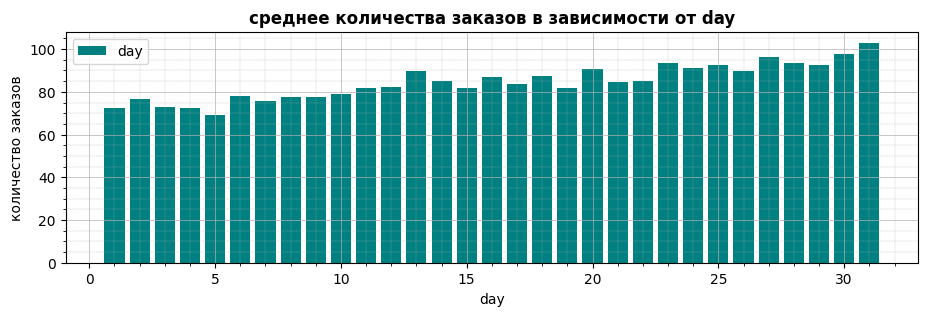

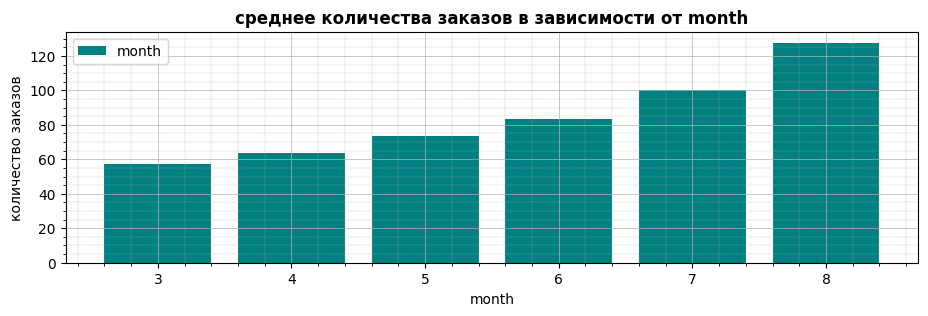

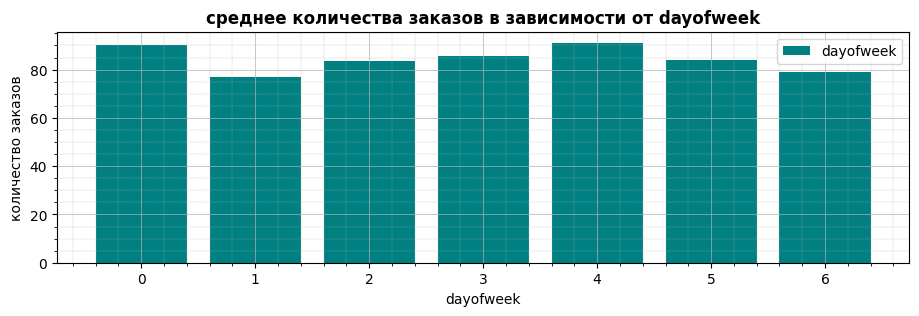

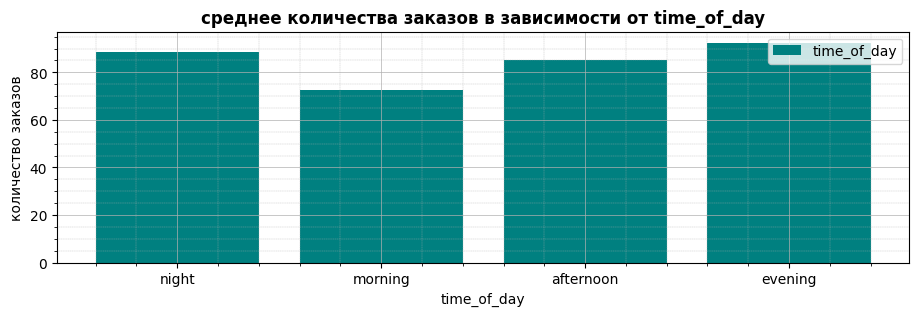

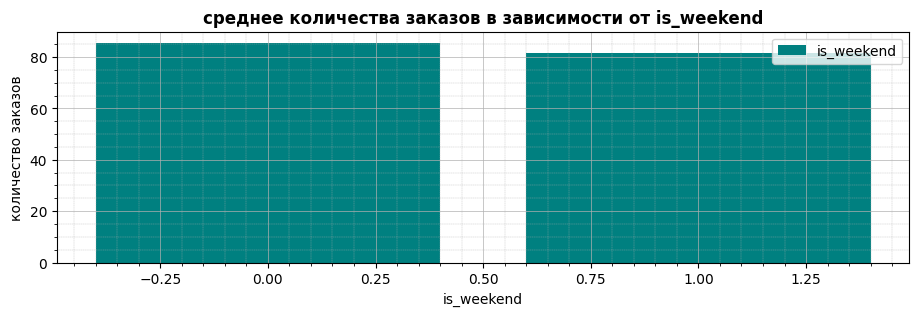

In [11]:
for i in ['day', 'month', 'dayofweek', 'time_of_day', 'is_weekend']:
    plot_grouped(df, i)

- видим, что в конце месяца количество заказов растёт, растёт оно и из месяца в месяц, что хорошо - сервис такси не стоит на месте и развивается. 
- пятница - самый активный день, по вторникам же с заказами хуже всего. Известно, что в некоторых направлених интернет-торговли вторник является самым провальным днём, во многом это связано с тем, что многие закупаются на неделю вперёд в выходные, во вторник же бывает совсем не до заказов. Применительно к такси такая логика не должна работать. Возможно, на некоторое падение количества заказов именно на этот день влияет то, что на вторник обычно назначают меньше деловых встреч и событий, которые могут требовать перемещения по городу. В целом на эту особенность стоит обращать внимание, нет ли сбоя в данных.
- вечер - самое активное время дня
- в выходные количество заказов такси ожидаемо падает

Посмотрим на количество заказов и движущееся среднее в разбивке по два месяца на график:

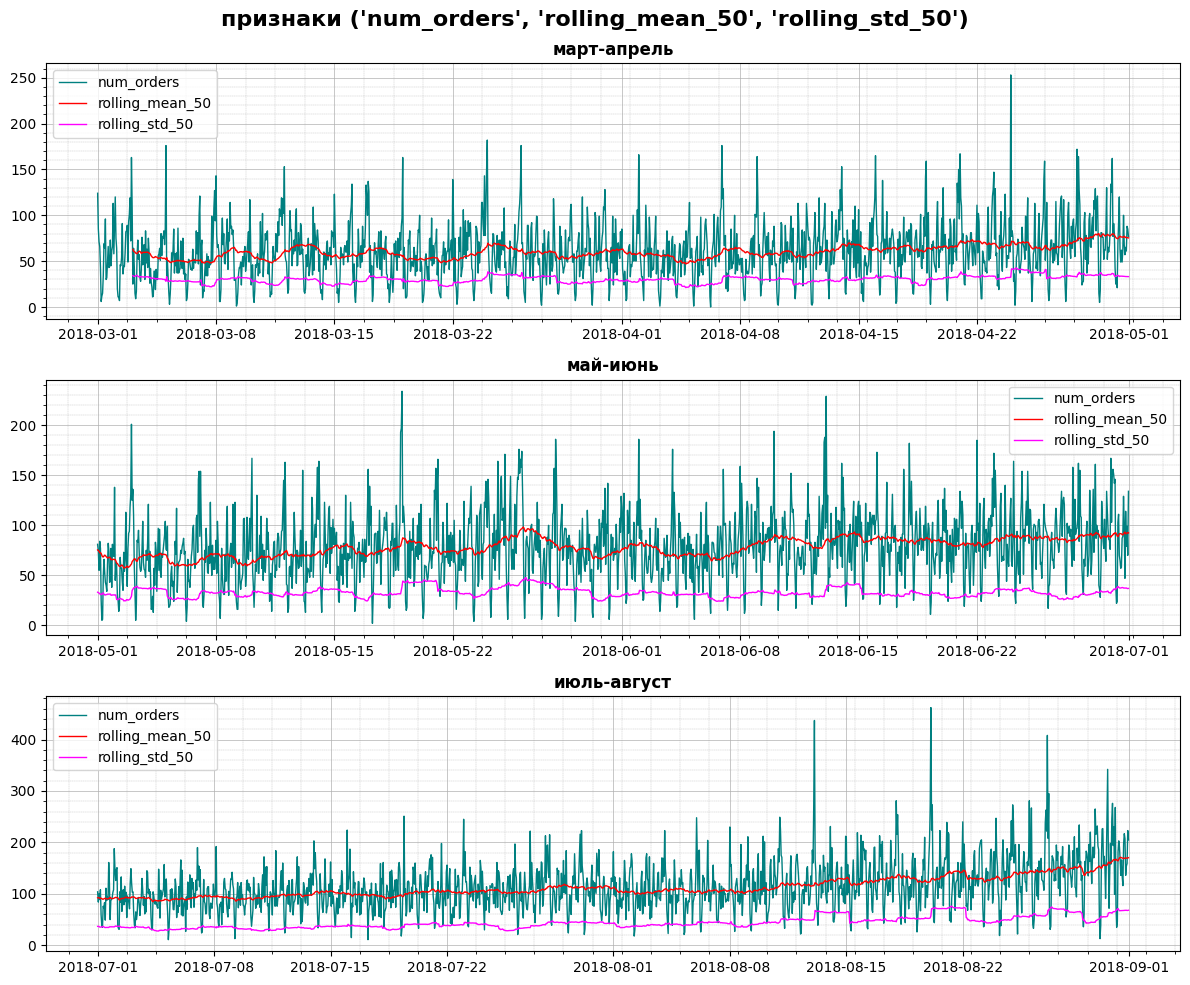

In [12]:
get_plot_by_month_2(df, 'num_orders', 'rolling_mean_50', 'rolling_std_50')

Количество заказов из месяца в месяц медленно, но верно растёт, ну это мы установили и ранее.

По росту значений на графике мы можем предположить о том, что временной ряд у нас нестационарный. Так ли это? Проверим при помощи расширенного теста Дики-Фуллера (ADF, вот [статья](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0) о нём в Википедии). Сформулируем гипотезы:

- $H_0$: временной ряд имеет единичный корень, то есть он нестационарен
- $H_1$: временной ряд не имеет единичного корня, то есть он стационарен

Что интересно:
- возьмём уровень значимости $\alpha=5\%$ и получим то, что:

In [13]:
adf_test(df['num_orders'], alpha=.05)

p-value = 0.0289
Отвергаем нулевую гипотезу о наличии единичного корня. Временной ряд стационарен.


- а при уровенe значимости $\alpha=1\%$:

In [14]:
adf_test(df['num_orders'], alpha=.01)

p-value = 0.0289
Не удалось отвергнуть нулевую гипотезу о наличии единичного корня. Временной ряд нестационарен.


На такую особенность данных, при которой результат теста меняется в зависимости от уровня значимости, могло повлиять множеством различных факторов, даже размер самой выборки. Будем помнить о том, что стационарность временного ряда не является абсолютным свойством и она может изменяться в зависимости от периода анализа и выбранного уровня значимости. Так что в контексте нашей задачи, помимо стат. теста, поверим и своим глазам и примем за вывод заключение о том, что наш временной ряд нестационарен.

Попробуем изучить внимательней тренд и возможную сезонность, применимв метод декомпозиции и отстроив соответствующие графики:

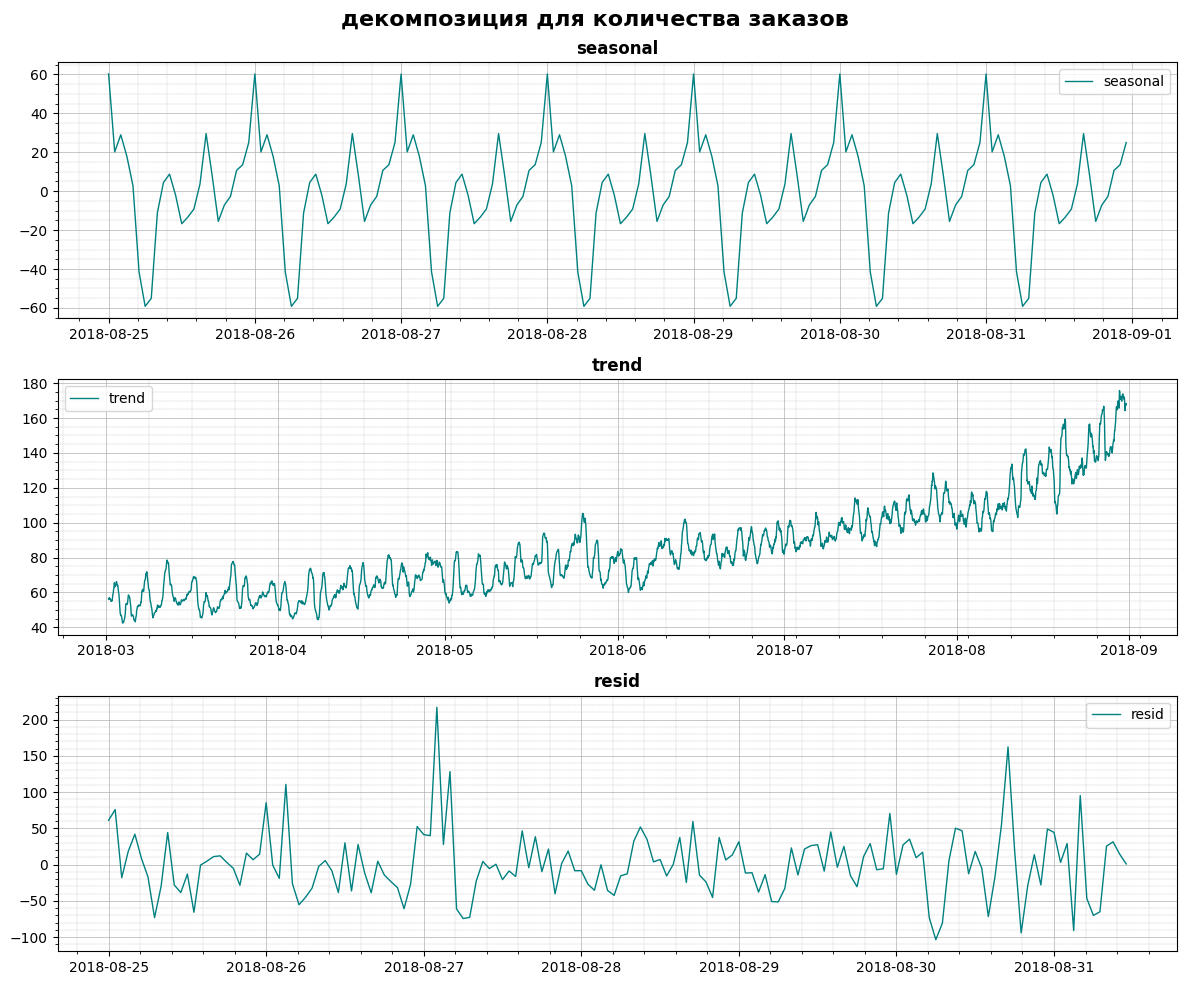

In [15]:
decomposed = seasonal_decompose(df['num_orders'])
decomposed_plot(decomposed.seasonal.tail(24*7), decomposed.trend, decomposed.resid.tail(24*7))

- видим сезонность - в нашем примере был взять диапазон последней недели, по которому отчётливо видно, что ближе к вечеру и ночи количество заказов растёт
- видим очевидный тренд - количество заказов такси за 6 месяцев идёт вверх

Построим график автокорреляции временного ряда для выявленного сезона в 24 лага:

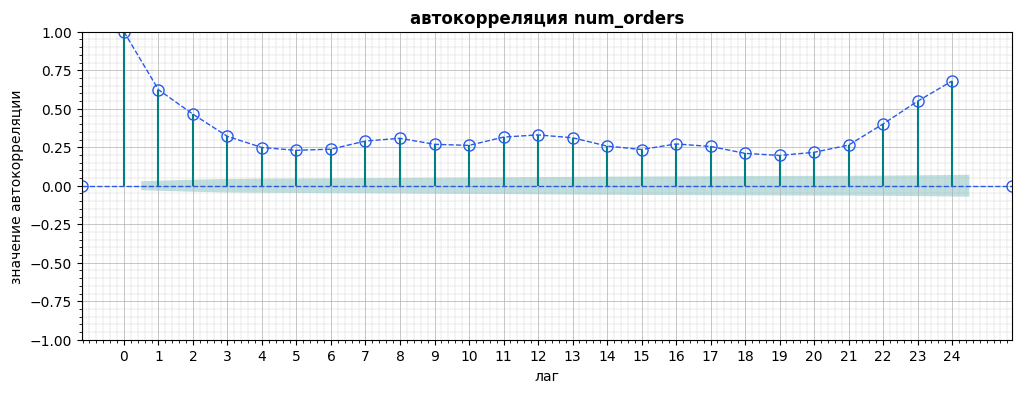

In [16]:
autocorrelation_plot(df['num_orders'], 24)

Значения автокорреляции > 0.5 на 1-м, 23-м и 24-м лаге указывают на наличие зависимости в данных, а это значит то, что значения заказов такси в какой-то конкретный час прямо связаны с предыдущими значениями заказов в течение последних суток $\Rightarrow$ если в предыдущие дни в определенное время было много заказов, то скорее всего такая же тенденция будет и в текущий день в то же самое время. Вот теперь мы точно и показали и доказали сезонность в имеющихся у нас данных.

### Предварительный вывод. На данном этапе мы:
- проанализировали имеющиеся в нашем распоряжении данные, применив к ним различные агрегации и группировки и отрисовав полученные результаты на графиках. И вот что мы обнаружили:
  - количество заказов такси от месяца к месяцу растёт и это тренд временных рядов
  - количество заказов изменяется в зависимости от времени суток и в этом есть сезонность
  - количество заказов в дни недели различно и пятница - самый активный день недели
  - количество заказов такси в будние дни вышем, чем в выходные
  - среднее количество заказов в разные дни месяца растёт ближе к концу
  - и вообще среднее значение имеет тенденцию к росту, а значит временные ряды нестационарны, что подтверждается и ADF-тестом при уровне значимости в 1%
  
Данные изучены и мы можем переходить к подготовке моделей машинного обучения

_____

## Обучение

Первым делом разделим выборку на обучающую и тестовую, выделив на тест 10% данных и удалив пропуски из тренировочной выборки:

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=.1)
train = train.dropna()

y_train = train['num_orders']
y_test = test['num_orders']

X_train = train.drop(columns='num_orders')
X_test = test.drop(columns='num_orders')

In [18]:
print(f'размеры:\n\t{X_train.shape=}, {y_train.shape=}\n\t'
      f'{X_test.shape= },  {y_test.shape= }\nпропуски в данных:\n\t'
      f'{X_train.isna().sum().sum()=}\n\t{X_test.isna().sum().sum()=}')

размеры:
	X_train.shape=(3924, 22), y_train.shape=(3924,)
	X_test.shape= (442, 22),  y_test.shape= (442,)
пропуски в данных:
	X_train.isna().sum().sum()=0
	X_test.isna().sum().sum()=0


Обученные пайплайны с полученными предсказаниями сложим в отдельный список, потом лучшие модели будем доставать из него по индексу и обучать тренировочные данные:

In [19]:
pipeline_and_predicts_list = list()

#### Lasso

перберём для Lasso и Ridge одинаковые параметры:
- *alpha* - сила L2-регуляризации
- *fit_intercept* - нужно ли добавлять intercept в модель
- *tol* - определяет, насколько должно измениться значение функции потерь (ошибки модели) при прекращении итераций алгоритма

In [20]:
%%time
model = Lasso()
params = {
    'regressor__alpha': [.001, .01, .1, 1, 10, 100],
    'regressor__fit_intercept': [False, True],
    'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6]
}
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params, linear_model=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

CPU times: total: 6.12 s
Wall time: 51.1 s


,модель,RMSE на train
0,"Lasso(alpha=0.01, tol=0.001)",26.13


#### Ridge

In [21]:
%%time
model = Ridge()
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params, linear_model=True)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))
table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

CPU times: total: 1.78 s
Wall time: 4.96 s


,модель,RMSE на train
1,Ridge(alpha=1),26.0


#### CatBoost Regressor
для него и для ```LGBMRegressor``` переберём:
- *n_estimators* - количество алгоритмов-деревьев
- *learning_rate* - скорость обучения

In [22]:
%%time
model = CatBoostRegressor(verbose=False)
params = {
    'regressor__n_estimators': [50, 100, 200, 250, 300],
    'regressor__learning_rate': [.01, .1, 1] 
}
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append(('CatBoostRegressor', pipeline, y_pred_train))

table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

CPU times: total: 17.2 s
Wall time: 10min 20s


,модель,RMSE на train
2,<catboost.core.CatBoostRegressor object at 0x000001FA7440D4C0>,25.44


#### Light Gradient Boosting Machine Regression

In [23]:
%%time
model = LGBMRegressor()

pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))

table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

CPU times: total: 1min 6s
Wall time: 2min 37s


,модель,RMSE на train
3,"LGBMRegressor(learning_rate=0.01, n_estimators=300)",26.1


#### Support Vector Machines Regression

Для метода опорных векторов рассмотрим вот что:
- *С* - резуляризация, отвечающая за баланс между точностью модели и её сложностью
- *gamma* - определяет гладкость разделяющей гипероплоскости

In [24]:
%%time
model = SVR()
params = {
    'regressor__C': [0.1, 1, 10],
    'regressor__gamma': ['scale', 'auto']
}
pipeline, table_row, y_pred_train =\
    choosing_best_model(model, X_train, y_train, params=params)

pipeline_and_predicts_list.append((type(model).__name__, pipeline, y_pred_train))


table_row.pivot_table.drop(columns='RMSE на test').iloc[[-1]].round(2)

CPU times: total: 10.4 s
Wall time: 39.2 s


,модель,RMSE на train
4,SVR(C=10),28.93


### Предварительный вывод. На данном этапе мы:
- написали функцию choosing_best_model, которая:
  - по разному, в зависимости от переданных ей гиперпараметров, трансформирует данные:
    - на кросс-валидации подбирает лучшие гиперпараметры и обучает пайплайн
    - заполняет строку в сводной таблице значениями:
      - название модели
      - значение RMSE для train (если поднять флаг, вернёт и для test)
    - и возвращает:
      - обученный пайплайн
      - вектор с предсказаниями
Обучили и получили предсказания ит замеры времени для следующих алгоритмов:
  - линейные:
    - LinearRegression
    - Ridge
  - градиентные бустинги:
    - LGBMRegressor
    - CatBoostRegressor

Все полученные значения собраны в сводную таблицу и список pipeline_and_predicts_list и готовы к анализу

_____

## Тестирование

Алгоритмы отработали, посмотрим, какие результаты они получили, в единой сводной таблице, отсортировав её по значению *RMSE*:

,модель,RMSE на train
2,<catboost.core.CatBoostRegressor object at 0x000001FA7440D4C0>,25.44
1,Ridge(alpha=1),26.00
3,"LGBMRegressor(learning_rate=0.01, n_estimators=300)",26.10
0,"Lasso(alpha=0.01, tol=0.001)",26.13
4,SVR(C=10),28.93


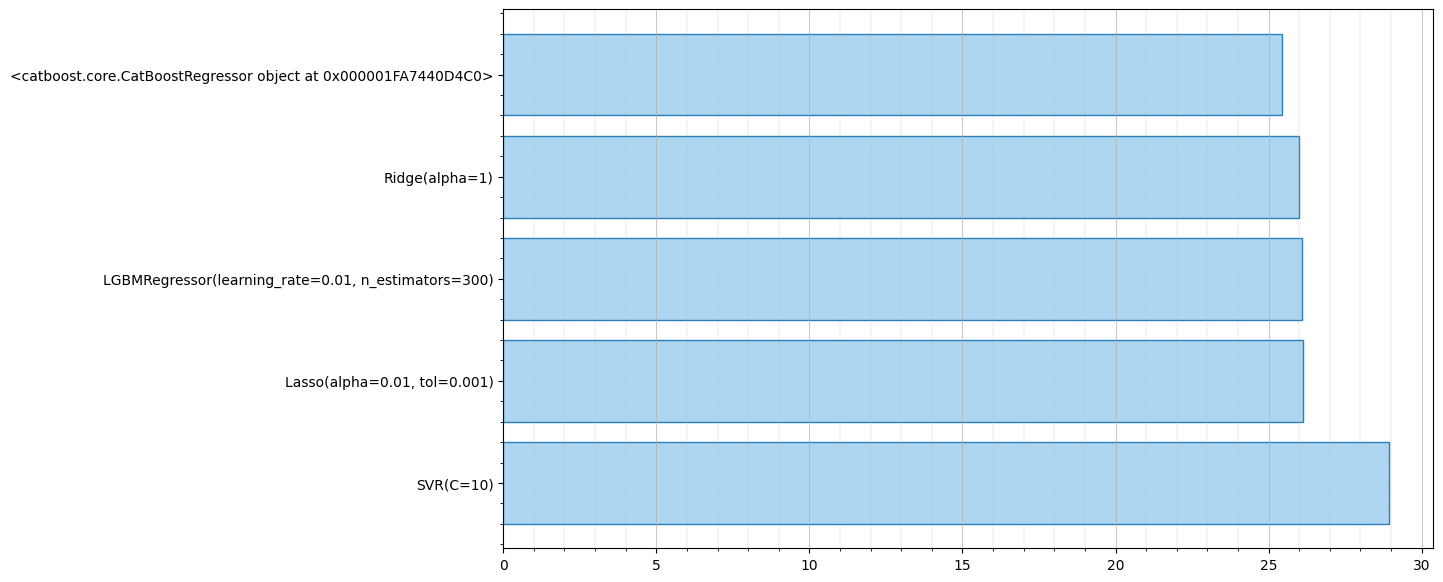

In [25]:
display(table_row.pivot_table.drop(columns='RMSE на test').sort_values('RMSE на train').round(2))
bar_ = table_row.pivot_table.drop(columns='RMSE на test').sort_values('RMSE на train')[::-1].round(2)
get_bar(bar_['модель'], bar_['RMSE на train'], '', '', '', h=True)

По сводной таблице и графику мы видим то, что:
- Catboost - лидер предсказания на тренировочных данных
- линейные модели иак же оказались молодцы, за счёт создания полиномиальных признаков в пайплайне они смогли учесть нелинейные зависимости между признаками и количеством заказов такси, и это здорово их подтянуло
- а вот SVR оказался в хвосте, этому алгоритму в нашей задаче, пожалуй, доверять не стоит

В целом результаты у всех алгоритмов получились настолько хорошими, что вызывают подозрения, так как порог, ниже которого не может быть *RMSE* на отолженной выборке не должен превышать 48. Эта цифра взята явно не с потолка, но продиктована бизнес-логикой компании «Чётенькое такси». Все наши модели этот порог успешно обогнали и перегнали, во многом им это удалось за счёт полиномиальных признаков и добавления большого количества лагов $\Rightarrow$ для нивелирования создавшегося эффекта переобучения в качестве финальной модели рассмотрим не один алгоритм, а лучший ансамбль из пары алгоритмов.

Обученные пайплайны и векторы с полученными предсказаниями у нас лежат в списке *pipeline_and_predicts_list* 
 мы с помощью *itertools.combinations* в цикле переберём все пары алгоритмов и посчитаем *RMSE* на их усреднённых предсказаниях, результат добавим в нашу сводную таблицу и посмотрим на ТОП-5 алгоритмов, отфильтровар таблицу по лучшему значению RMSE:

In [26]:
predictions_list = [predictions for _, _, predictions in pipeline_and_predicts_list]
model_names = [model_name for model_name, _, _ in pipeline_and_predicts_list]

for pair in itertools.combinations(model_names, 2):
    indices = [model_names.index(index_model) for index_model in pair]       # получаем индексы моделей
    predictions_subset = [predictions_list[i] for i in indices]
    
    ensemble_predictions = sum(predictions_subset) / len(predictions_subset) # усредняем предсказания
    rmse = mean_squared_error(y_train, ensemble_predictions, squared=False)
    ensemble_name = '-'.join(pair)                                           # строка с названием композиции
    table_row = GetFinalTable(ensemble_name, rmse, '')
table_row.pivot_table.drop(columns='RMSE на test').sort_values('RMSE на train').head(5).round(2)

,модель,RMSE на train
12,CatBoostRegressor-LGBMRegressor,16.91
9,Ridge-CatBoostRegressor,19.61
13,CatBoostRegressor-SVR,19.71
6,Lasso-CatBoostRegressor,19.72
10,Ridge-LGBMRegressor,20.59


Лучшей парой алгоритмов оказалось сочетание двух разных бустингов - это:
- CatBoostRegressor (обученный пайплайн в списке под индексом 2)
- LGBMRegressor (обученный пайплайн в списке под индексом 3)

Несмотря на то, что в "турнирной таблице" они оказались на втором месте, мы остановим свой выбор на них, так как в паре два бустинга от разных производителей должны давай более стабильный результат

Посмотрим на пайплайны выбранных нами моделей, обративгись к ним по индексу в списке *pipeline_and_predicts_list*:

In [27]:
display(pipeline_and_predicts_list[2][1], pipeline_and_predicts_list[3][1])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_of_day']),
                                                 ('num', PolynomialFeatures(),
                                                  ['month', 'day', 'dayofweek',
                                                   'is_weekend',
                                                   'orders_prev_day',
                                                   'rolling_mean_5',
                                                   'rolling_mean_50',
                                                   'rolling_std_5',
                                                   'rolling_std_50', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time_of_day']),
                                                 ('num', PolynomialFeatures(),
                                                  ['month', 'day', 'dayofweek',
                                                   'is_weekend',
                                                   'orders_prev_day',
                                                   'rolling_mean_5',
                                                   'rolling_mean_50',
                                                   'rolling_std_5',
                                                   'rolling_std_50', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                 

$\Rightarrow$ получим от них предсказание на тестовых данных и посчитаем итоговое значение метрики RMSE:

In [28]:
y_test_predict_first = pipeline_and_predicts_list[2][1].predict(X_test)
y_test_predict_second = pipeline_and_predicts_list[3][1].predict(X_test)
y_test_predict = np.array([y_test_predict_first, y_test_predict_second]).mean(axis=0)

table_row = GetFinalTable(f'{pipeline_and_predicts_list[2][0]} + {pipeline_and_predicts_list[3][0]}',
                          '', mean_squared_error(y_test, y_test_predict, squared=False))
table_row.pivot_table.drop(columns='RMSE на train').iloc[[-1]]

,модель,RMSE на test
15,CatBoostRegressor + LGBMRegressor,42.850151


Получилось не такое хорошее значение, как было на тренировочных данных. Это говорит о том, что ансамбль алгоритмов всё же немного переобучился, но по отдельности наверняка результат был бы неустойчивее и хуже. И, самое главное, мы получили значение *RSME* ниже предельного порога в 48 единиц (заказов)

Для полной уверенности в том, что наш алгоритм действительно работает, проверим его на адекватность, сравнив полученное предсказание с предсказанием, формируемым при помощи предыдущего значения временного ряда. Итоговый результат для сравнения выведем в таблице и визуализируем:

,модель,RMSE на test
15,CatBoostRegressor + LGBMRegressor,42.850151
16,константная-модель,58.856486


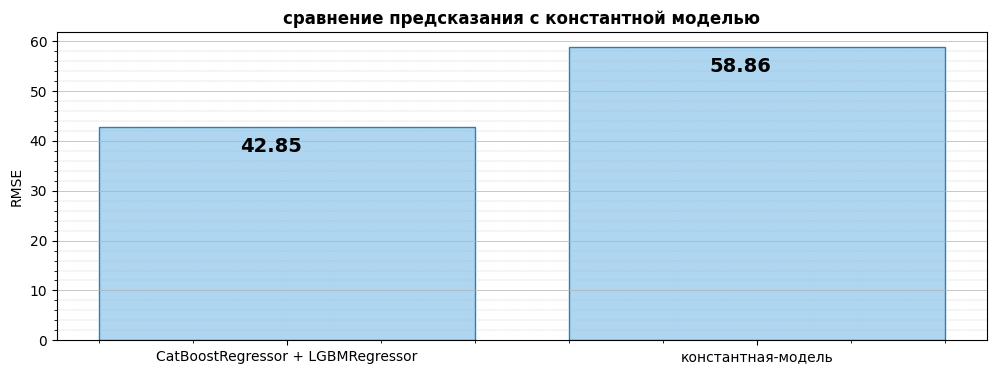

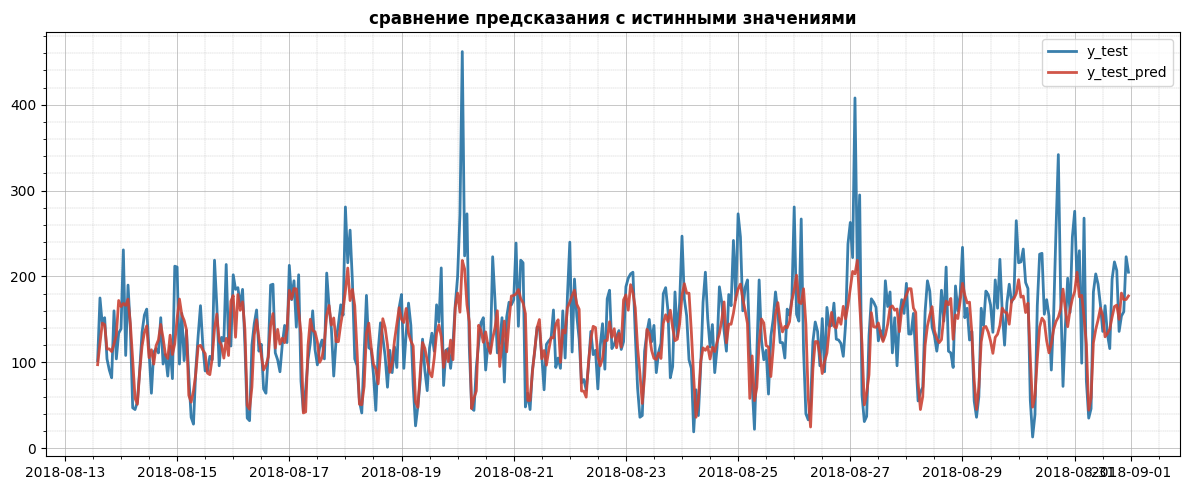

In [29]:
pred_start_from_train = y_test.shift(fill_value=y_train.tail(1).values[0])

table_row = GetFinalTable('константная-модель', '', mean_squared_error(
    y_test, pred_start_from_train, squared=False))
compare_result = table_row.pivot_table.drop(columns='RMSE на train').iloc[[-2, -1]]
display(compare_result)
get_bar(compare_result['модель'], compare_result['RMSE на test'], '', 'RMSE', 
        'сравнение предсказания с константной моделью', rmse_=compare_result['RMSE на test'].values)
final_forecast_plot(pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_predict}))

На графиках мы явно видим то, что наша модель проходит проверку на вменяемость и предсказывает не абы что, а действительные значения

Сравнивая на графике реальные значения с предсказанными нельзя не отметить то, что предсказание довольно точно следует временному ряду, описывающему заказ такси за последние 18 с хвостиком дней и придерживается сезона в 24 часа, согласно которому количество заказов ближе к вечеру и ночи растёт

Может показаться то, что модель несколько пессимистична в своих предсказаниях, но это не так, модель практически никогда не выходит за минимальные значения, а максимальные "вспышки" переваливших за 400 шт. заказов, пришедшиеся на:
- ночь 20-го августа ([вот что тогда происходило](https://www.interfax.ru/news/2018/08/20))
- ночь 27-го августа ([вот что тогда происходило](https://www.interfax.ru/news/2018/08/27))

Довольно трудно объясняются не то, что моделью, но и рациональными рассуждениями. 20 августа отмечался [Всемирный день лени](https://www.calend.ru/day/2018-8-20/), а 27-го - [День независимости Молдовы](https://www.calend.ru/day/2018-8-27/), оба этих события никак не располагают к резкому росту заказов такси в аэропорты. Так что природа подобных вспышек сама по себе требует уточнения у сотрудников «Чётенького такси», отвечающих за сбор, обработку и хранения информации, пока же мы можем выдвинуть два предположения относительно природы подобных резких скачков в количестве заказов:
  - место имел какой-то технический сбор
  - место имел какой-то нестандартный корпоративный заказ

И та и другая предполагаемая причина резкого однократного "роста заказов" требует к себе отдельного внимательного нестандартного подхода. Так что, выходит, даже хорошо то, что наша модель не выпрыгивает за пределы вменяемого диапазона значений и ведёт себя разумней людей, отмечавших 20-го августа день лени))

Напоследок - сохраним обученные пайплайны для будущих работ:

In [30]:
folder_name = 'pipelines'
try:
    os.mkdir(folder_name)
except FileExistsError:
    pass

joblib.dump(pipeline_and_predicts_list[2][1], os.path.join(folder_name, f'pipeline_CatBoost'))
joblib.dump(pipeline_and_predicts_list[3][1], os.path.join(folder_name, f'pipeline_XGB'))

### Предварительный вывод. На данном этапе мы:
- оценили модели, полученные ранее, с точки зрения качества предсказания
- в борьбе с возможным переобучением составили попарные ансамбли всех разработанных моделей
- выбрали лучший ансамбль, получили по нему предсказание на отложенной выборке
- проверили разработанный алгоритм на адекватность, сравнив полученный результат с предсказанием, формируемым при помощи предыдущего значения временного ряда
- оценили качество полученного предсказания, визуализировав его на одном графике с истинными значениями
- сохранили обученный пайплайны в файлы, в дальнейшем к ним можно юудет обращаться

_____

## Общий вывод

Для компании «Чётенькое такси» мы разработали модель машинного обучения, основанную на двух алгоритмах градиентного бустинга. Представленная нами модель прогнозирует количество заказов такси на предстоящий час и этим должна помочь компании в распределении водителей в периоды пиковой загруженности.

Для разработки модели нами были проделаны следующие шаги:
- исследованы предоставленные данные
- на основании полученной информации сформированы признаки, на базе которых обучались модели 
- подготовлены разные виды моделей машинного обучения на основе таких алгоритмов:
  - 2 линейных:
    - Lasso
    - Ridge
  - 2 деревянных (бустинги):
    - LGBMRegressor
    - CatBoostRegressor c OneHotEncoder
  - 1 метод опорных векторов:
    - SVR
- на базе подготовленных ML-моделей алгоритмов созданы их попарные ансамбли и в итоге выбрана лучшая пара, которая стала основой разработанного нами решения

В итоге нам удалось подготовить модель, которая прогнозирует количество заказов такси на следующий час, возвращая значение ошибки предсказания MSE = 42 шт. Для сравнения - "проверочное" предсказание, формируемое при помощи предыдущего значения временного ряда по среднему даёт значение ошибки = 59 шт.

Исходя из полученных результатов, можно сделать вывод о том, что разработанная нами модель является эффективной и может быть использована компанией "Чётенькое такси" для оптимизации работы водителей. Она станет важным инструментом для компании и позволит не только оптимизировать имеющиеся бизнес-процессы, но и повысить уровень обслуживания клиентов в целом.

_____